In [1]:
from tensorly.metrics.regression import RMSE
from tensorly.decomposition import parafac
import time
import scipy.io
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorly.cp_tensor import CPTensor
from parafac_normalization_comparison import *
import musicntd.model.features as features
import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import soundfile as sf
#audio
data,sampling_rate = sf.read('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

#Parameters
rank=10
init='random'
hop_length = 512
n_fft = hop_length * 4
hop_length_seconds = hop_length/sampling_rate


stft_spec = features.get_spectrogram(data[:,0], sampling_rate, 
                                     feature="stft", n_fft = n_fft, hop_length = hop_length)
bars = dm.get_bars_from_audio('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

tensor = tf.tensorize_barwise(stft_spec, bars, hop_length_seconds, 40)

/usr/local/lib64/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


hop_length a 44100Hz = 512, normal ?


1. Method from PR
2. Inner loop normalization with last factor normalization after inner loop
3. Normalization at the end
4. 2 and 3 together
5. Current tensorly normalizationn

In [2]:
#normalized improved parafac result
tic = time.time()
tensornorm1, errorsnorm1 = parafac_normalize_1(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True)
weightsnorm1, factorsnorm1 = tensornorm1
cp_reconstructionnorm1 = tl.cp_to_tensor((weightsnorm1, factorsnorm1))
time_cp1 = time.time()-tic


#normalized improved parafac result
tic = time.time()
tensornorm2, errorsnorm2 = parafac_normalize_2(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True)
weightsnorm2, factorsnorm2 = tensornorm2
cp_reconstructionnorm2 = tl.cp_to_tensor((weightsnorm2, factorsnorm2))
time_cp2 = time.time()-tic


#normalized improved parafac result
tic = time.time()
tensornorm3, errorsnorm3 = parafac_normalize_3(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True)
weightsnorm3, factorsnorm3 = tensornorm3
cp_reconstructionnorm3 = tl.cp_to_tensor((weightsnorm3, factorsnorm3))
time_cp3 = time.time()-tic


#normalized improved parafac result
tic = time.time()
tensornorm4, errorsnorm4 = parafac_normalize_4(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True)
weightsnorm4, factorsnorm4 = tensornorm4
cp_reconstructionnorm4 = tl.cp_to_tensor((weightsnorm4, factorsnorm4))
time_cp4 = time.time()-tic

#normalized improved parafac result
tic = time.time()
tensornorm5, errorsnorm5 = parafac(tensor, rank=rank, init=init, normalize_factors=True, return_errors=True)
weightsnorm5, factorsnorm5 = tensornorm5
cp_reconstructionnorm5 = tl.cp_to_tensor((weightsnorm5, factorsnorm5))
time_cp5 = time.time()-tic

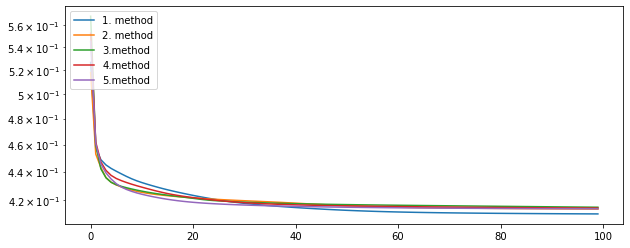

In [3]:
each_iteration(errorsnorm1, errorsnorm2, errorsnorm3, errorsnorm4, errorsnorm5)

In [4]:
print(weightsnorm1[:5])
print(weightsnorm2[:5])
print(weightsnorm3[:5])
print(weightsnorm4[:5])
print(weightsnorm5[:5])

[323672.47 184921.06 369814.28 346773.12 390563.66]
[272588.38 133722.5  376102.06 215450.12 252000.3 ]
[364063.22 525463.5  483019.66 336517.28 454274.03]
[246404.12 305024.12 509604.1  422376.2  665266.94]
[252365.44 227960.02 363352.78 743706.4  646487.56]


In [5]:
print(tl.mean(factorsnorm1[0]), tl.mean(factorsnorm1[1]), tl.mean(factorsnorm1[2]))
print(tl.mean(factorsnorm2[0]), tl.mean(factorsnorm2[1]), tl.mean(factorsnorm2[2]))
print(tl.mean(factorsnorm3[0]), tl.mean(factorsnorm3[1]), tl.mean(factorsnorm3[2]))
print(tl.mean(factorsnorm4[0]), tl.mean(factorsnorm4[1]), tl.mean(factorsnorm4[2]))
print(tl.mean(factorsnorm5[0]), tl.mean(factorsnorm5[1]), tl.mean(factorsnorm5[2]))

0.0014120829 0.078468174 0.046030037
0.0012279634 0.077498175 0.055359647
0.0013430404 0.09980422 0.046225857
0.0012794543 0.0803625 0.058514018
0.0018876971 0.10370991 0.03229199


In [6]:
print(RMSE(tensor,cp_reconstructionnorm1))
print(RMSE(tensor,cp_reconstructionnorm2))
print(RMSE(tensor,cp_reconstructionnorm3))
print(RMSE(tensor,cp_reconstructionnorm4))
print(RMSE(tensor,cp_reconstructionnorm5))

162.05089
163.33656
163.83968
163.61522
163.41693


In [7]:
print(str(time_cp1))
print(str(time_cp2))
print(str(time_cp3))
print(str(time_cp4))
print(str(time_cp5))

6.996006965637207
6.786243438720703
6.95613956451416
6.199885606765747
6.37337589263916
